# Test du solveur par transport optimal

Le but de ce notebook est d'analyser les résultats fournis par notre solveur par transport optimal, défini dans un précédent notebook.

## Code du solveur

Voici le code précédemment généré pour le solveur.

In [1]:
import ot
import scipy.optimize, scipy.signal
import numpy as np
import matplotlib.pyplot as plt

def frequential_cost_matrix(F):
    """
    Generates a frequential cost matrix, i.e. the frequency moving cost.
    ---
    Inputs:
        - F : 1-D float array. The range of frequencies to be considered.
    ---
    Outputs
        - C : 2-D float array. The wanted cost matrix.
    """
    M = F.shape[0]
    C = np.zeros((M,M))
    for i in range(M):
        for j in range(M):
            C[i,j] = (F[i]-F[j])**2
    return C

def simplex_OT_canonical_matrices(v, W, C):
    """
    Generates the canonical matrices for the simplex algorithm.
    ---
    Inputs:
        - v : 1-D float array. The target trame to be matched.
        - W : 2-D float array. The signal dictionnary.
        - C : 2-D float array. The frequential cost matrix.
    ---
    Outputs:
        - c : 1-D float array. The objective function vector for the simplex algorithm 
                    (i.e. the flattened cost matrix).
        - A : 2-D float array. The left-side (variables sided) equality matrix for the simplex algorithm.
        - b : 1-D float array. The right-side (value constraints) equality vector for the simplex algorithm.
    """
    M = v.shape[0]
    K = W.shape[1]
    # Coefficients for minimization
    c = np.zeros((M**2+ K,))
    #Constraints matrix and vertice
    A = np.zeros((2*M,M**2+ K))
    b = np.zeros((2*M,))
    
    # c is unfolding C and letting zeros after
    c[:M**2] =  [C[i//M, i%M] for i in range(M**2)]
    
    # Writing first constraints set
    for i in range(M):
        for j in range(M):
            A[i, i*M+j] = 1
        b[i] = v[i] 
    
    # Writing second constraints set
    for j in range(M):
        for i in range(M):
            A[M + j, i*M+j] = 1
        for k in range(K):
            A[M + j, M**2 +k] = -W[j,k]
    
    # Returning matrices
    return c, A, b

def simplex_algorithm(c, A, b):
    """
    Returns the optimal solution found by the simplex algorithm.
    ---
    Inputs:
        - c : 1-D float array. The objective function vector for the simplex algorithm 
                    (i.e. the flattened cost matrix).
        - A : 2-D float array. The left-side (variables sided) equality matrix for the simplex algorithm.
        - b : 1-D float array. The right-side (value constraints) equality vector for the simplex algorithm.
    ---
    Outputs:
        - x : 1-D float array. The simplex's optimal solution, 
                    i.e. the vector that minimizes <c.x>, 
                    so that Ax = b.            
    """
    #result = scipy.optimize.linprog(c, method="simplex", options={'A':A, 'b':b})
    result = scipy.optimize.linprog(c, A_eq=A, b_eq=b,bounds=(0, None))
    if not result.success:
        print("Failure: ", result.message)
    print("Simplex iterations:", result.nit)
    return result.x

def compute_NMF(v,W,C):
    """
    Computes a Non-negative Matrix Factorization of v based on W, optimizing with respects to C.
    ---
    Inputs:
        - v : 1-D float array. The target trame to be matched.
        - W : 2-D float array. The signal dictionnary.
        - C : 2-D float array. The frequential cost matrix.
    ---
    Outputs:
        - h : 1-D float array. An optimal vector so that v ~ Wh, with respects to C.
    """
    c, A, b = simplex_OT_canonical_matrices(v, W, C)
    th = simplex_algorithm(c, A, b)
    K = W.shape[1]
    h = th[-K:]
    return h

def slice_spectrogram(f, t, S, fmin=0, fmax=50000):
    """
    Slices the frequences of a spectrogram.
    -- 
    Inputs:
        - f : 1-D float array. The spectrogram's frequency values.
        - t : 1-D float array. The spectrogram's time values.
        - S : 2-D float array. The spectrogram.
    ---
    Parameters:
        - fmin : float. The spectrogram slice's minimal frequency.
        - fmax : float. The spectrogram slice's maximal frequency.
    ---
    Outputs:
        - f : 1-D float array. The sliced spectrogram's frequency values.
        - t : 1-D float array. The sliced spectrogram's time values.
        - S : 2-D float array. The slicespectrogram.
    """
    freq_slice = np.where((f >= fmin) & (f <= fmax) )

    f = f[freq_slice]
    S = S[freq_slice,:][0]

    return f, t, S

def get_spectrogram(s, fs, fmin=0, fmax=50000, nperseg = 1024):
    """
    Returns the spectrogram of a signal s.
    ---
    Inputs:
        - s : 1-D float array. The considered signal.
        - fs : float. The sampling frequency of the signal.
    ---
    Parameters:
        - fmin : float. The spectrogram slice's minimal frequency.
        - fmax : float. The spectrogram slice's maximal frequency.
        - nperseg : int. Number of samples per spectrogram segment. 
                         Note that it results in lesser time samples in the spectrogram.
    ---
    Outputs:
        - f : 1-D float array. The spectrogram's frequency values.
        - t : 1-D float array. The spectrogram's time values.
        - S : 2-D float array. The spectrogram.
    """
    f, t, S = scipy.signal.spectrogram(s, fs=fs, nperseg= nperseg)
    f, t, S = slice_spectrogram(f, t, S, fmin, fmax)
    return f, t, S

def normalize_trame(v):
    """
    Normalizes a spectrogram trame v.
    ---
    Inputs:
        - v : 1-D float array. The spectrogram trame
    ---
    Outputs:
        - normalized_v: 1-D float array. The normalized spectrogram trame
    """
    normalized_v = v/np.sum(v)
    return normalized_v

## Génération des signaux de base

On définit ici plusieurs signaux de base pour pouvoir les manipuler.

In [2]:
# Sample frequency
fs = 10e4
# Values amount
N = 10000
# Time
T = np.arange(N) / fs

f_test,t_test, S_test = get_spectrogram(np.array([0]*N), fs)
#print(f_test)
print("Frequencies amount", len(f_test))

# Base frequencies, conveniently aligned on scipy.signal base values.
base_freqs = [
               390.625,
               1562.5,
               3125,
               4296.875
             ]



elementary_signals = [np.sin(2*np.pi*f*T) for f in base_freqs]
# Base signals
base_signals = elementary_signals.copy()

Frequencies amount 513


On définit également un bruit blanc, afin de pouvoir bruiter nos signaux.

In [3]:
import random
# White noise, i.e a random signal
white_noise = [random.random()/10 for t in T]

## Génération du dictionnaire

Nous définissons désormais notre dictionnaire à l'aide de nos signaux de base.

52
(52, 11)
(52, 4) = 52 4
-----


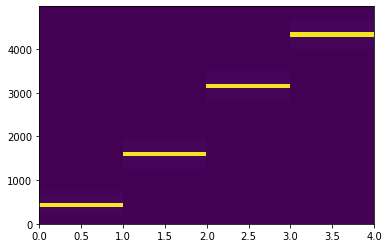

In [4]:
# Cutting frequencies
FMIN = 0
FMAX = 5000

# Computing the spectrograms
spectrograms = [get_spectrogram(s, fs,  FMIN, FMAX)[0] for s in base_signals]
f, t, S = get_spectrogram(base_signals[0], fs,  FMIN, FMAX)
print(len(f))
print(S.shape)

# Dimensions :
# M: number of examples
K = len(base_signals)
# N: number of considered frequencies
M = len(f)
# N: number of samples
N = len(t)

# Dictionnary declaration (assumes that base signal are frequency constant through time)
W = np.array([normalize_trame(get_spectrogram(s, fs,  FMIN, FMAX)[-1][:,N//2]) for s in base_signals]).transpose()


print(W.shape, "=", M,K)
print("-----")
plt.pcolormesh(range(K+1), f, W)
plt.show()

## Génération de la matrice de coût

Nous générons enfin la matrice de coût associée.

In [5]:
C = frequential_cost_matrix(f)/1000

## Génération d'un signal-jouet

Nous définissons ici les signaux de test.

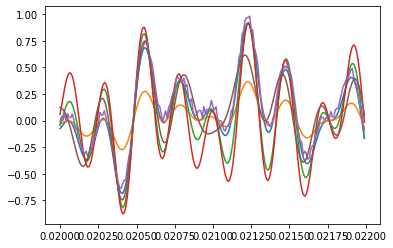

In [6]:
# First, simple signal. Same amplitude, with all coefficients equals.
coeffs1 = [1/len(base_signals) for s in base_signals]
s1 = np.dot(coeffs1, base_signals)

# Augmented amplitude
coeffs2 = [0.1 for s in base_signals]
s2 = np.dot(coeffs2, base_signals)

# Custom coefficients - All signals presents
coeffs3 = [0.1,0.2,0.3,0.4]
s3 = np.dot(coeffs3, base_signals)

# A signal is not component
coeffs4 = [0,0.25,0.25,0.5]
s4 = np.dot(coeffs4, base_signals)

# Noisy signal
coeffs5 = coeffs1
s5 = s1 + white_noise

# Let us trick a bit, by adding a signal absent from the dictionnary.
coeffs6 = [0.2,0.2,0.2,0.2]
f6 = 3515.625
s6 = np.dot(coeffs6, base_signals) + np.array([0.2*np.sin(2*np.pi*f6*t) for t in T])

start_index = 2000
size = 200
plt.plot(T[start_index:start_index+size],s1[start_index:start_index+size])
plt.plot(T[start_index:start_index+size],s2[start_index:start_index+size])
plt.plot(T[start_index:start_index+size],s3[start_index:start_index+size])
plt.plot(T[start_index:start_index+size],s4[start_index:start_index+size])
plt.plot(T[start_index:start_index+size],s5[start_index:start_index+size])
plt.plot(T[start_index:start_index+size],s6[start_index:start_index+size])
plt.show()

Nous calculons ensuite les spectrogrammes.

In [7]:
f1, t1, S1 = get_spectrogram(s1, fs, fmin=FMIN, fmax=FMAX)
f2, t2, S2 = get_spectrogram(s2, fs, fmin=FMIN, fmax=FMAX)
f3, t3, S3 = get_spectrogram(s3, fs, fmin=FMIN, fmax=FMAX)
f4, t4, S4 = get_spectrogram(s4, fs, fmin=FMIN, fmax=FMAX)
f5, t5, S5 = get_spectrogram(s5, fs, fmin=FMIN, fmax=FMAX)
f6, t6, S6 = get_spectrogram(s6, fs, fmin=FMIN, fmax=FMAX)

Et enfin nous calculons une trame de ce spectrogramme.

Fréquences : [390.625, 1562.5, 3125, 4296.875]
Fréquences de v1


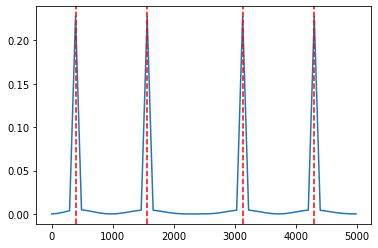

Fréquences de v2 (identiques à v1)


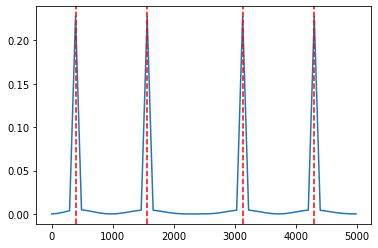

Fréquences de v3 (déséquilibré)


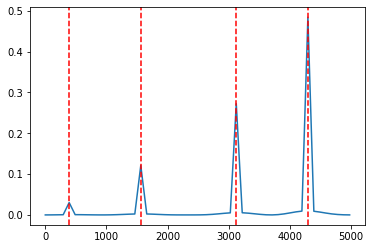

Fréquences de v4 (pas de f1)


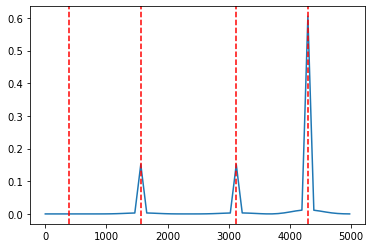

Fréquences de v5 (bruit)


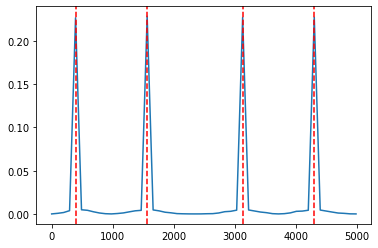

Fréquences de v6 (signal étranger)


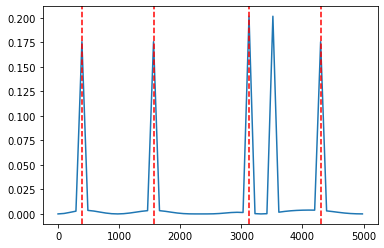

In [8]:
v1 = normalize_trame(S1[:,N//2])
v2 = normalize_trame(S2[:,N//2])
v3 = normalize_trame(S3[:,N//2])
v4 = normalize_trame(S4[:,N//2])
v5 = normalize_trame(S5[:,N//2])
v6 = normalize_trame(S6[:,N//2])

print("Fréquences :", base_freqs)

print("Fréquences de v1")
plt.plot(f,v1)
for freq in base_freqs:
    plt.axvline(freq, color = "red", linestyle = "--")
plt.show()
print("Fréquences de v2 (identiques à v1)")
plt.plot(f,v2)
for freq in base_freqs:
    plt.axvline(freq, color = "red", linestyle = "--")
plt.show()
print("Fréquences de v3 (déséquilibré)")
plt.plot(f,v3)
for freq in base_freqs:
    plt.axvline(freq, color = "red", linestyle = "--")
plt.show()
print("Fréquences de v4 (pas de f1)")
plt.plot(f,v4)
for freq in base_freqs:
    plt.axvline(freq, color = "red", linestyle = "--")
plt.show()
print("Fréquences de v5 (bruit)")
plt.plot(f,v5)
for freq in base_freqs:
    plt.axvline(freq, color = "red", linestyle = "--")
plt.show()
print("Fréquences de v6 (signal étranger)")
plt.plot(f,v6)
for freq in base_freqs:
    plt.axvline(freq, color = "red", linestyle = "--")
plt.show()

### Analyse de la méthode

Évaluons si le choix d'une trame arbitraire, justifiée par la constance temporelle, est vraiment pertinent

Spectrogrammes des signaux de base


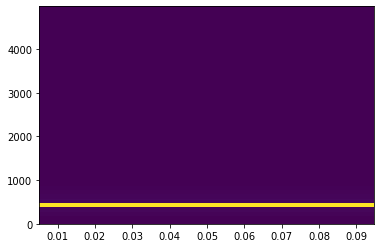

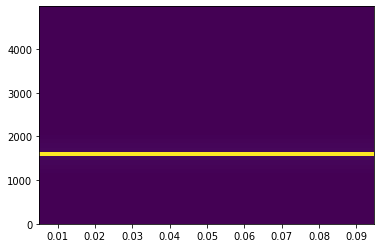

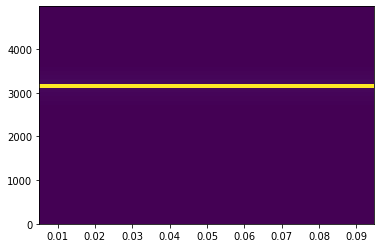

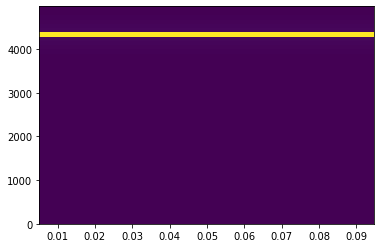

---
Spectrogramme du signal combiné


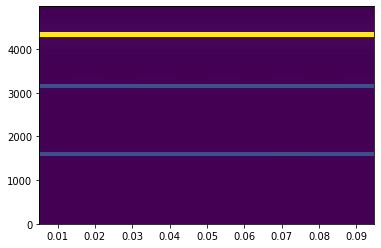

---
Somme des spectrogrammes


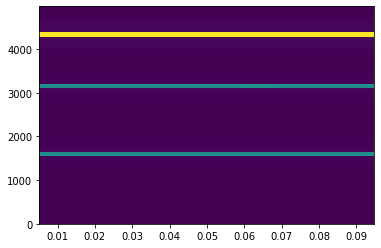

---
Valeurs non nulles de S4 en N//2:  [0.0002903703703703699, 0.00029037037037037746, 0.0011614814814814838]
Valeurs non nulles de sum_specs en N//2 :  [0.0011614814814814804, 0.0011614814814814814, 0.002322962962962969]
Normalisé :
Valeurs non nulles de S4 en N//2:  [0.15123771122521587, 0.15123771122521978, 0.6049508449008656]
Valeurs non nulles de sum_specs en N//2 :  [0.22685507289316972, 0.22685507289316995, 0.45371014578634106]
---
Valeurs non nulles de S4 en moyenne:  [0.00029037037037037047, 0.00029037037037037323, 0.001161481481481482]
Valeurs non nulles de sum_specs en moyenne:  [0.0011614814814814814, 0.0011614814814814817, 0.002322962962962964]
Normalisé :
Valeurs non nulles de S4 en moyenne:  [0.15123740127265647, 0.1512374012726579, 0.604949605090626]
Valeurs non nulles de sum_specs en moyenne:  [0.22685507289317017, 0.22685507289317022, 0.4537101457863406]


In [9]:
specs = np.array([get_spectrogram(s, fs,  FMIN, FMAX)[-1] for s in base_signals])
print("Spectrogrammes des signaux de base")
for spectro in specs:
    plt.pcolormesh(t4,f4,spectro)
    plt.show()
print("---")
print("Spectrogramme du signal combiné")
plt.pcolormesh(t4,f4,S4)
plt.show()
print("---")
print("Somme des spectrogrammes")
specs_sum = coeffs4[0]*specs[0] + coeffs4[1]*specs[1] + coeffs4[2]*specs[2] + coeffs4[3]*specs[3]
plt.pcolormesh(t4,f4, specs_sum)
plt.show()
print("---")
print("Valeurs non nulles de S4 en N//2: ",[v for v in S4[:,N//2] if v > 10e-5])
print("Valeurs non nulles de sum_specs en N//2 : ",[v for v in specs_sum[:,N//2] if v > 10e-5])
print("Normalisé :")
print("Valeurs non nulles de S4 en N//2: ",[v for v in normalize_trame(S4[:,N//2]) if v > 10e-2])
print("Valeurs non nulles de sum_specs en N//2 : ",[v for v in normalize_trame(specs_sum[:,N//2]) if v > 10e-2])
print("---")
print("Valeurs non nulles de S4 en moyenne: ",[v for v in np.mean(S4, axis = 1) if v > 10e-5])
print("Valeurs non nulles de sum_specs en moyenne: ",[v for v in np.mean(specs_sum, axis = 1) if v > 10e-5])
print("Normalisé :")
print("Valeurs non nulles de S4 en moyenne: ",[v for v in normalize_trame(np.mean(S4, axis = 1)) if v > 10e-2])
print("Valeurs non nulles de sum_specs en moyenne: ",[v for v in normalize_trame(np.mean(specs_sum, axis = 1)) if v > 10e-2])



On observe que les valeurs sont différentes (et non proportionnelles) !

## Tests

Nous passons désormais aux tests

In [10]:
print("--- Cas de base")
print("h1 = ", compute_NMF(v1,W,C))
print("Note : devrait être proche de", coeffs1/np.sum(coeffs1))
print()
print("--- Amplitude modifiée")
print("h2 = ", compute_NMF(v2,W,C))
print("Note : devrait être proche de", coeffs2/np.sum(coeffs2))
print()
print("--- Coefficients variables")
print("h3 = ", compute_NMF(v3,W,C))
print("Note : devrait être proche de", coeffs3/np.sum(coeffs3))
print()
print("--- Un signal absent")
print("h4 = ", compute_NMF(v4,W,C))
print("Note : devrait être proche de", coeffs4/np.sum(coeffs4))
print()
print("--- Signal bruité")
print("h5 = ", compute_NMF(v5,W,C))
print("Note : devrait être proche de", coeffs5/np.sum(coeffs5))
print()
print("--- Signal avec une composante inconnue")
print("h6 = ", compute_NMF(v6,W,C))
print("Note : devrait être proche de", coeffs6/np.sum(coeffs6))

--- Cas de base
Simplex iterations: 24
h1 =  [0.24648879 0.25119205 0.2511684  0.25115077]
Note : devrait être proche de [0.25 0.25 0.25 0.25]

--- Amplitude modifiée
Simplex iterations: 24
h2 =  [0.24648879 0.25119205 0.2511684  0.25115077]
Note : devrait être proche de [0.25 0.25 0.25 0.25]

--- Coefficients variables
Simplex iterations: 25
h3 =  [0.03271756 0.13344153 0.300165   0.53367591]
Note : devrait être proche de [0.1 0.2 0.3 0.4]

--- Un signal absent
Simplex iterations: 25
h4 =  [1.27409764e-06 1.66674039e-01 1.66716709e-01 6.66607977e-01]
Note : devrait être proche de [0.   0.25 0.25 0.5 ]

--- Signal bruité
Simplex iterations: 23
h5 =  [0.24570251 0.2523332  0.25075124 0.25121306]
Note : devrait être proche de [0.25 0.25 0.25 0.25]

--- Signal avec une composante inconnue
Simplex iterations: 23
h6 =  [0.18993298 0.19356503 0.41265778 0.20384421]
Note : devrait être proche de [0.25 0.25 0.25 0.25]


## Altération du dictionnaire

Complexifions désormais notre dictionnaire en lui donnant une composante composée de deux signaux élémentaires

##############################
(52, 4) = 52 4
-----


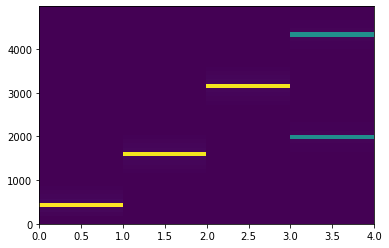

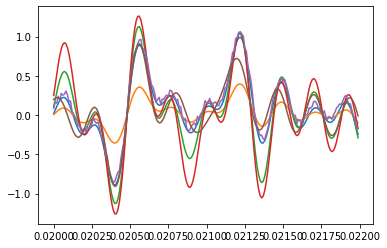

##############################


In [11]:
base_signals_bis = elementary_signals.copy()
base_signals_bis[3] += np.sin(2*np.pi*1953.125*T)

# Computing the spectrograms
spectrograms_bis = [get_spectrogram(s, fs,  FMIN, FMAX)[0] for s in base_signals]

# Dictionnary declaration (assumes that base signal are frequency constant through time)
W_bis = np.array([normalize_trame(get_spectrogram(s, fs,  FMIN, FMAX)[-1][:,N//2]) for s in base_signals_bis]).transpose()

####################################################################################################################
print("#"*30)

print(W_bis.shape, "=", M,K)
print("-----")
plt.pcolormesh(range(K+1), f, W_bis)
plt.show()

# First, simple signal. Same amplitude, with all coefficients equals.
coeffs1_bis = [1/len(base_signals_bis) for s in base_signals_bis]
s1_bis = np.dot(coeffs1_bis, base_signals_bis)

# Augmented amplitude
coeffs2_bis = [0.1 for s in base_signals_bis]
s2_bis = np.dot(coeffs2_bis, base_signals_bis)

# Custom coefficients - All signals presents
coeffs3_bis = [0.1,0.2,0.3,0.4]
s3_bis = np.dot(coeffs3_bis, base_signals_bis)

# A signal is not component
coeffs4_bis = [0,0.25,0.25,0.5]
s4_bis = np.dot(coeffs4_bis, base_signals_bis)

# Noisy signal
coeffs5_bis = coeffs1_bis
s5_bis = s1_bis + white_noise

# Let us trick a bit, by adding a signal absent from the dictionnary.
coeffs6_bis = [0.2,0.2,0.2,0.2]
f6_bis = 3515.625
#trash = np.dot(coeffs6_bis, base_signals_bis)
#print(trash.shape)
#trash2= np.array([0.2*np.sin(2*np.pi*f6_bis*t) for t in T])
#print(trash2.shape)
s6_bis = np.dot(coeffs6_bis, base_signals_bis) + np.array([0.2*np.sin(2*np.pi*f6_bis*t) for t in T])

start_index = 2000
size = 200
plt.plot(T[start_index:start_index+size],s1_bis[start_index:start_index+size])
plt.plot(T[start_index:start_index+size],s2_bis[start_index:start_index+size])
plt.plot(T[start_index:start_index+size],s3_bis[start_index:start_index+size])
plt.plot(T[start_index:start_index+size],s4_bis[start_index:start_index+size])
plt.plot(T[start_index:start_index+size],s5_bis[start_index:start_index+size])
plt.plot(T[start_index:start_index+size],s6_bis[start_index:start_index+size])
plt.show()

####################################################################################################################
print("#"*30)

f1_bis, t1_bis, S1_bis = get_spectrogram(s1_bis, fs, fmin=FMIN, fmax=FMAX)
f2_bis, t2_bis, S2_bis = get_spectrogram(s2_bis, fs, fmin=FMIN, fmax=FMAX)
f3_bis, t3_bis, S3_bis = get_spectrogram(s3_bis, fs, fmin=FMIN, fmax=FMAX)
f4_bis, t4_bis, S4_bis = get_spectrogram(s4_bis, fs, fmin=FMIN, fmax=FMAX)
f5_bis, t5_bis, S5_bis = get_spectrogram(s5_bis, fs, fmin=FMIN, fmax=FMAX)
f6_bis, t6_bis, S6_bis = get_spectrogram(s6_bis, fs, fmin=FMIN, fmax=FMAX)

####################################################################################################################
v1_bis = normalize_trame(S1_bis[:,N//2])
v2_bis = normalize_trame(S2_bis[:,N//2])
v3_bis = normalize_trame(S3_bis[:,N//2])
v4_bis = normalize_trame(S4_bis[:,N//2])
v5_bis = normalize_trame(S5_bis[:,N//2])
v6_bis = normalize_trame(S6_bis[:,N//2])

Observons les résultats de cette résolution :

In [12]:
print("--- Cas de base")
print("h1 = ", compute_NMF(v1_bis,W_bis,C))
print("Note : devrait être proche de =", coeffs1_bis/np.sum(coeffs1_bis))
print()
print("--- Amplitude modifiée")
print("h2 = ", compute_NMF(v2_bis,W_bis,C))
print("Note : devrait être proche de =", coeffs2_bis/np.sum(coeffs2_bis))
print()
print("--- Coefficients variables")
print("h3 = ", compute_NMF(v3_bis,W_bis,C))
print("Note : devrait être proche de =", coeffs3_bis/np.sum(coeffs3_bis))
print()
print("--- Un signal absent")
print("h4 = ", compute_NMF(v4_bis,W_bis,C))
print("Note : devrait être proche de =", coeffs4_bis/np.sum(coeffs4_bis))
print()
print("--- Signal bruité")
print("h5 = ", compute_NMF(v5_bis,W_bis,C))
print("Note : devrait être proche de =", coeffs5_bis/np.sum(coeffs5_bis))
print()
print("--- Signal avec une composante inconnue")
print("h6 = ", compute_NMF(v6_bis,W_bis,C))
print("Note : devrait être proche de =", coeffs6_bis/np.sum(coeffs6_bis))

--- Cas de base
Simplex iterations: 25
h1 =  [0.19126079 0.22333607 0.19499769 0.39040545]
Note : devrait être proche de = [0.25 0.25 0.25 0.25]

--- Amplitude modifiée
Simplex iterations: 25
h2 =  [0.19126079 0.22333607 0.19499769 0.39040545]
Note : devrait être proche de = [0.25 0.25 0.25 0.25]

--- Coefficients variables
Simplex iterations: 24
h3 =  [0.0207863  0.1092191  0.19088595 0.67910866]
Note : devrait être proche de = [0.1 0.2 0.3 0.4]

--- Un signal absent
Simplex iterations: 27
h4 =  [1.42939532e-06 1.25334662e-01 9.72269145e-02 7.77436994e-01]
Note : devrait être proche de = [0.   0.25 0.25 0.5 ]

--- Signal bruité
Simplex iterations: 23
h5 =  [0.19049376 0.22469309 0.19451455 0.3902986 ]
Note : devrait être proche de = [0.25 0.25 0.25 0.25]

--- Signal avec une composante inconnue
Simplex iterations: 23
h6 =  [0.15539946 0.17269625 0.33795027 0.33395403]
Note : devrait être proche de = [0.25 0.25 0.25 0.25]


On note que la précision faiblit fortement. **Cependant**, il est à noter que la tendance globale semble conservée. Il est donc possible que cela soit fortement amélioré par le spectrogramme.

# Simulation des signaux EEG

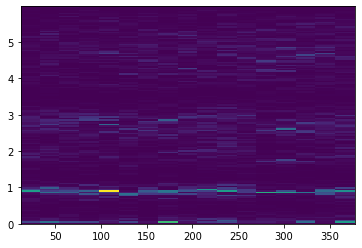

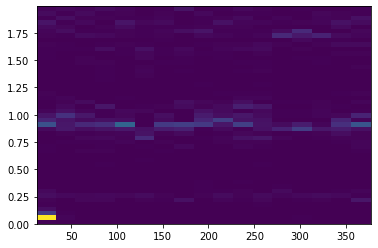

In [13]:
import h5py
eeg_examples_file = '../EEG_Data/example_BCG_artifact.mat'

with h5py.File(eeg_examples_file, 'r') as f:
    ecg_mat = f['ecg']
    eeg_c_mat = f['eeg_c']
    eeg_fp_mat = f['eeg_fp']
    eeg_o_mat = f['eeg_fp']
    eeg_p_mat = f['eeg_p']
    
    ecg_signal = np.array([v[0] for v in ecg_mat])
    eeg_fp_signal = np.array([v[0] for v in eeg_c_mat])
    
    ffp, tfp, Sfp =get_spectrogram(eeg_fp_signal, fs=10e2/6, fmax = 6, nperseg = 4096)
    plt.pcolormesh(tfp,ffp,Sfp)
    plt.show()
    fc, tc, Sc =get_spectrogram(ecg_signal, fs=10e2/6, fmax = 2, nperseg = 4096)
    plt.pcolormesh(tc,fc,Sc)
    plt.show()

In [14]:
toy_pulse_artifact = 0
toy_gradient_artifact = 0

SyntaxError: invalid syntax (<ipython-input-14-20c0e6afc8b5>, line 1)